In [1]:
from sympy.solvers import solve
from sympy import symbols
from scipy.integrate import solve_ivp
import numpy as np
import scipy.integrate as it
import pdb

In [2]:
a1,b1,c1,d1,e1,f1 = symbols('a1 b1 c1 d1 e1 f1') 
a2,b2,c2,d2,e2,f2= symbols('a2 b2 c2 d2 e2 f2') 
t = symbols('t')

In [3]:
eq_pos_t1 = a1*t**5 + b1*t**4 + c1*t**3 + d1*t**2 + e1*t + f1 
eq_vel_t1 = e1 + 2*d1*t + 3*c1*t**2 + 4*b1*t**3 + 5*a1*t**4
eq_acc_t1 = 2*d1 + 6*c1*t + 12*b1*t**2 + 20*a1*t**3

eq_pos_t2 = a2*t**5 + b2*t**4 + c2*t**3 + d2*t**2 + e2*t + f2 
eq_vel_t2 = e2 + 2*d2*t + 3*c2*t**2 + 4*b2*t**3 + 5*a2*t**4
eq_acc_t2 = 2*d2 + 6*c2*t + 12*b2*t**2 + 20*a2*t**3

In [4]:
theta1_bvp={'pos':[[0,2],[-np.pi/4., np.pi/4.]], 'vel':[[0,2],[0,0]], 'acc':[[0,2],[0,0]]}
#create the boundary value problem for theta1

In [5]:
theta2_bvp={'pos':[[0,2],[0., np.pi/2.]], 'vel':[[0,2],[0,0]], 'acc':[[0,2],[0,0]]}
#create the boundary value problem for theta2

In [6]:
#trajectory generator function returns the coefficients of the polynomials 
def trajGen(theta1_bvp, theta2_bvp):
    expr_list_t1 =  []
    for i in range(len(theta1_bvp['pos'][0])): 
        expr_list_t1.append(eq_pos_t1.subs(t,theta1_bvp['pos'][0][i])-theta1_bvp['pos'][1][i])
    for i in range(len(theta1_bvp['vel'][0])): 
        expr_list_t1.append(eq_vel_t1.subs(t,theta1_bvp['vel'][0][i])-theta1_bvp['vel'][1][i])
    for i in range(len(theta1_bvp['vel'][0])): 
        expr_list_t1.append(eq_acc_t1.subs(t,theta1_bvp['acc'][0][i])-theta1_bvp['acc'][1][i])
    expr_list_t2 =  []
    for i in range(len(theta2_bvp['pos'][0])): 
        expr_list_t2.append(eq_pos_t2.subs(t,theta2_bvp['pos'][0][i])-theta2_bvp['pos'][1][i])
    for i in range(len(theta2_bvp['vel'][0])): 
        expr_list_t2.append(eq_vel_t2.subs(t,theta2_bvp['vel'][0][i])-theta2_bvp['vel'][1][i])
    for i in range(len(theta2_bvp['vel'][0])): 
        expr_list_t2.append(eq_acc_t2.subs(t,theta2_bvp['acc'][0][i])-theta2_bvp['acc'][1][i])
    return solve(expr_list_t1), solve(expr_list_t2)

In [7]:
#get the coeffecients 
theta1co, theta2co = trajGen(theta1_bvp, theta2_bvp)
# theta1co
# print(theta2co)

In [8]:
#takes the time and the coefficients gives the value of the q,qdot,qddot q=theta1,theta2
def trajectory(time1, theta1co, theta2co): 
    theta1co[t]=time1
    theta2co[t]=time1
    q = [eq_pos_t1.subs(theta1co),eq_pos_t2.subs(theta2co)]
    qdot = [eq_vel_t1.subs(theta1co),eq_vel_t2.subs(theta2co)]
    qddot = [eq_acc_t1.subs(theta1co),eq_acc_t2.subs(theta2co)]
    return q, qdot, qddot

In [9]:
q, qdot, qddot = trajectory(0, theta1co, theta2co) #test trajectory genrator

In [10]:
#I've rewritten the Differential equations as: 
# ddtheta1_d/dt^2
# eq3 = k1*u(t).diff(t) + k2*v(t).diff(t) - k3*u(t)*v(t) - k4*v(t)**2 - tau1 
# ddtheta2_d/dt^2
# eq4 = k5*u(t).diff(t) + k6*v(t).diff(t) - k7*u(t)*v(t) - tau2

In [11]:
def ddTh_dT(t, Y, th1, th2, th1dot, th2dot, Y3, Y4):
    # pass the current values as the initial values of theta, compute torque from PID
    m2 = 2.
    m1 = 3.
    I1 = 2.
    I2 = 1.
    L1 = 1.
    g = 9.8
    r1 = 0.5
    r2 = 0.5

    u = th1dot  # u = dtheta1_dt
    v = th2dot # v = dtheta2_dt
    th1 = th1  # theta1
    th2 = th2  # theta2

    tau1 = Y3  # Torque1
    tau2 = Y4  # Torque2

    k1 = I1 + m1 * r1 ** 2 + m2 * r2 ** 2 + m2 * L1 ** 2 + 2 * m2 * L1 * r2 * np.cos(th1)
    k2 = m2 * r2 ** 2 + m2 * L1 * r2 * np.cos(th2)
    k3 = 2. * L1 * m2 * r2 * np.sin(th2)
    k4 = 1. * L1 * m2 * r2 * np.sin(th2)
    k51 = g * ((m1 * r1 + m2 * L1) * np.cos(th1) + m2 * r2 * g * np.cos(th1 + th2))

    k5 = m2 * r2 ** 2 + m2 * L1 * r2 * np.cos(th2)
    k6 = m2 * r2 ** 2 + I2
    k7 = 1. * L1 * m2 * r2 * np.sin(th2)
    k8 = m2 * r2 * g * np.cos(th1 + th2)

    du_dt = -(((-k51) * k6 + k2 * k8 + k6 * tau1 - k2 * tau2 - k2 * k7 * u ** 2 + k3 * k6 * u * v + k4 * k6 * v ** 2) / (
                          k2 * k5 - k1 * k6))
    dv_dt = -(((-k5) * k51 + k1 * k8 + k5 * tau1 - k1 * tau2 - k1 * k7 * u ** 2 + k3 * k5 * u * v + k4 * k5 * v ** 2) / (
                          (-k2) * k5 + k1 * k6))
    
#     pdb.set_trace()

    
    return [Y[0], Y[1], du_dt, dv_dt]

Pseudocode for PID control
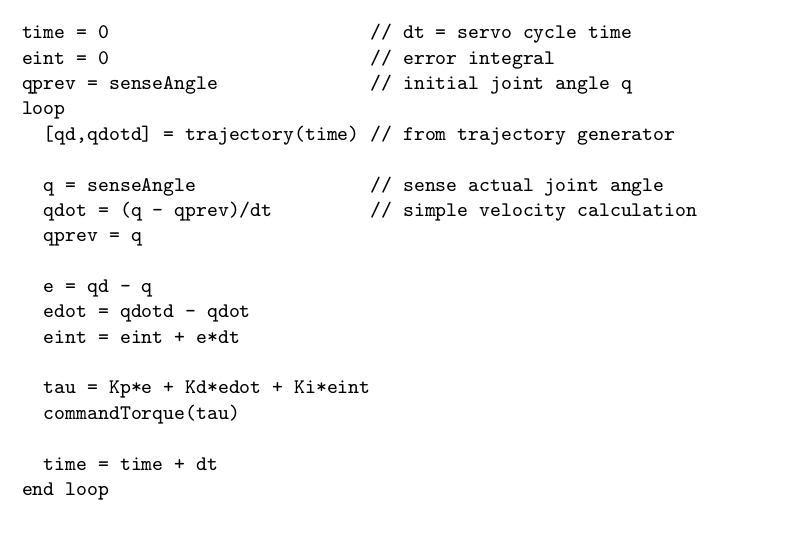
computing torques as 
$\tau = $

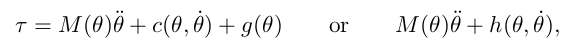
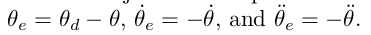
<!-- ![image-4.png](attachment:image-4.png) -->
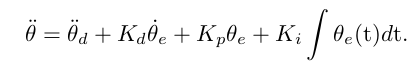
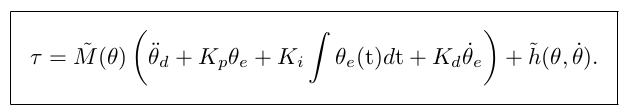


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
def pidLoop(t, q, qdot, qddot):

    theta1 = [float(q[0,0])]
    theta2 = [float(q[0,1])]
    theta1dot = [float(qdot[0,0])]
    theta2dot = [float(qdot[0,1])]
    theta1ddot = [float(qddot[0,0])]
    theta2ddot = [float(qddot[0,1])]

    #list for storing errors in theta2
    theta1_e = [1];
    theta1_edot = [0];
    theta1_eddot = [0];

    theta2_e = [1];
    theta2_edot = [0];
    theta2_eddot = [0];

    m2 = 2.
    m1 = 3.
    I1 = 2.
    I2 = 1.
    L1 = 1.
    g = 9.8
    r1 = 0.5
    r2 = 0.5

    Kp1 = 5.5
    Kd1 = 4
    Ki1 = 3.

    Kp2 = 5
    Kd2 = 3 
    Ki2 = 2
    
    dt = 1. / len(t)
    tau1_l = []
    tau2_l = []
    
    for i in range(len(t)):
#         print(t[i])
        theta1d = q[i,0]
        theta1dotd = qdot[i,0]
        theta1ddotd = qddot[i,0]

        theta2d = q[i,1]
        theta2dotd = qdot[i,1]
        theta2ddotd = qddot[i,1]

        # calucluate error;

        theta1_e.append(theta1d - theta1[-1])
        theta1_edot.append(theta1dotd - theta1dot[-1])
        theta1_eddot.append(theta1ddotd - theta1ddot[-1])

        theta2_e.append(theta2d - theta2[-1])
        theta2_edot.append(theta2dotd - theta2dot[-1])
        theta2_eddot.append( theta2ddotd - theta2ddot[-1])

        u1 = Kp1 * theta1_e[-1] + Kd1 * theta1_edot[-1] + Ki1 * it.simpson(theta1_e)


        u2 = Kp2 * theta2_e[-1] + Kd2 * theta2_edot[-1] + Ki2 * it.simpson(theta2_e)

        inp_pid = np.array([[u1], [u2]])

        td = np.array([[theta1dot[-1]], [theta2dot[-1]]])

        tdd = np.array([[theta1ddot[-1]], [theta2ddot[-1]]])

        M = np.array([[I1 + m1 * r1 ** 2 + m2 * r2 ** 2 + m2 * L1 ** 2 + 2 * m2 * L1 * r2 * np.cos(theta2[-1]),
                       m2 * r2 ** 2 + m2 * L1 * r2 * np.cos(theta2[-1])],
                      [m2 * r2 ** 2 + m2 * L1 * r2 * np.cos(theta2[-1]), m2 * r2 ** 2 + I2]])
        
        C = np.array([[-m2 * L1 * r2 * theta2ddot[-1] * np.sin(theta2[-1]),
                       -m2 * L1 * r2 * theta1ddot[-1] * np.sin(theta2[-1]) - m2 * L1 * r2 * theta2ddot[-1] * np.sin(
                           theta2[-1])], [m2 * L1 * r2 *theta1ddot[-1] * np.sin(theta1[-1]), 0]])

        G = np.array(
            [[g * ((m1 * r1 + m2 * L1) * np.cos(theta1[-1]) + m2 * r2 * g * np.cos(theta2[-1] + theta2[-1]))],
             [ m2 * r2 * g * np.cos(theta2[-1] + theta1[-1])]])
       
       
        result1 = M@(tdd+ inp_pid) + C@td + G
        tau1 = result1[0,0]*0.1
        tau2 = result1[1,0]*0.2
        theta_dots = solve_ivp(ddTh_dT,
                               [t[i], t[i] + dt],
                               [theta1[-1], theta2[-1], theta1dot[-1], theta2dot[-1]],
                               args=(theta1[-1], theta2[-1], theta1dot[-1], theta2dot[-1], tau1, tau2)
                               )
#         pdb.set_trace()
 
        theta1.append(it.simpson(theta_dots.y[2,:]))
        theta2.append(it.simpson(theta_dots.y[3,:]))
        theta1dot.append(theta_dots.y[2,-1]);
        theta2dot.append(theta_dots.y[3, -1]);
        theta1ddot.append(theta1dot[-2] - theta1dot[-1])
        theta2ddot.append(theta2dot[-2] - theta2dot[-1])
        tau1_l.append(tau1)
        tau2_l.append(tau2)
        
#     plt.plot(q[:,0], "-r", label="reference")
#     plt.plot(theta1, "-b", label="actual")
#     plt.legend(loc="upper left")
#     plt.xlabel("time steps")
#     plt.ylabel("theta1 value rads")
#     plt.show()

#     plt.plot(q[:,1], "-r", label="reference")
#     plt.plot(theta2, "-b", label="actual")
#     plt.legend(loc="upper left")
#     plt.xlabel("time steps")
#     plt.ylabel("theta2 value rads")
#     plt.show()


#     plt.plot(tau1_l, "-r", label="tau1")
#     plt.plot(tau2_l, "-b", label="tau2")
#     plt.legend(loc="upper left")
#     plt.xlabel("time steps")
#     plt.ylabel("tau value")
#     plt.show()
    return tau1_l, tau2_l, theta1, theta2

In [13]:
# Step 1 get desired q,qdot,qddot 
# Using the boundary value problem 
# theta1_bvp={'pos':[[0,2],[-pi/4., pi/4.]], 'vel':[[0,2],[0,0]], 'acc':[[0,2],[0,0]]}
# theta2_bvp={'pos':[[0,2],[0., pi/2.]], 'vel':[[0,2],[0,0]], 'acc':[[0,2],[0,0]]}
# Get coefficients of polynomials using 
# theta1co, theta2co = trajGen(theta1_bvp, theta2_bvp)

q = [] #{theta1,theta2}
qdot = [] #{theta1dot,theta2dot}
qddot = [] #{theta1ddot,theta2ddot}

timesteps = 50 #50 timesteps between 0-2
for i in np.linspace(0,2,timesteps):
    q1, qdot1, qddot1 = trajectory(i, theta1co, theta2co)
    q.append(q1)
    qdot.append(qdot1)
    qddot.append(qddot1)



q=np.array(q)
qdot=np.array(qdot)
qddot=np.array(qddot)

tau1_, tau2_, l_theta1_, l_theta2_ = pidLoop(np.linspace(0,2,timesteps), q, qdot, qddot)

In [14]:
def end_effector(theta1, theta2): 
    theta1 = np.array(theta1)
    theta2 = np.array(theta2)
    L1 = 1.
    L2 = 1.
    x1 = L1*np.cos(theta1)
    y1 = L1*np.sin(theta1)
    x2 = x1 + L2*np.cos(theta1+theta2)
    y2 = y1 + L2*np.sin(theta1+theta2)
    return (x1,y1,x2,y2)

In [15]:
x1,y1,x2,y2 = end_effector(l_theta1_, l_theta2_)

In [16]:
# q[:,0]

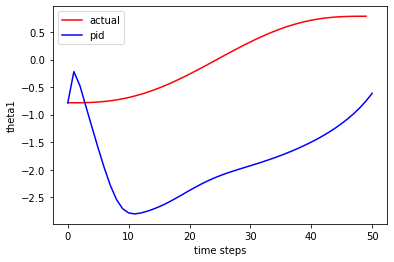

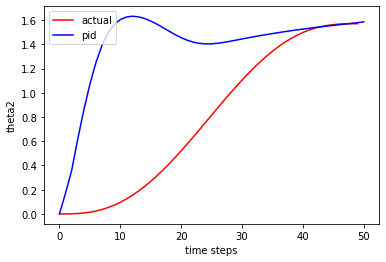

In [17]:
# the reference joint angles, actual joint angles,
plt.plot(q[:,0], "-r", label="actual")
plt.plot(l_theta1_, "-b", label="pid")
# plt.legend('theta1 actual, theta1 error', ncol=2, loc='upper left');
plt.legend(loc="upper left")
plt.xlabel("time steps")
plt.ylabel("theta1")
# plt.ylim(-100, 100)
plt.show()

plt.plot(q[:,1], "-r", label="actual")
plt.plot(l_theta2_, "-b", label="pid")
# plt.legend('theta1 actual, theta1 error', ncol=2, loc='upper left');
plt.legend(loc="upper left")
plt.xlabel("time steps")
plt.ylabel("theta2")
# plt.ylim(-100, 100)
plt.show()

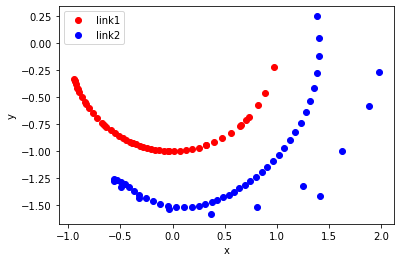

In [18]:
# end-effector motion in task space
plt.plot(x1, y1, "or", label="link1")
plt.plot(x2, y2, "ob", label="link2")
# plt.plot(x2,y2, "ob", label="link2")
# plt.legend('theta1 actual, theta1 error', ncol=2, loc='upper left');
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [19]:
x1[-1]

0.8177868877741167

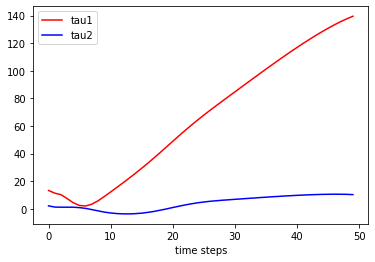

In [20]:
# torques
plt.plot(tau1_, "-r", label="tau1")
plt.plot(tau2_, "-b", label="tau2")
plt.legend(loc="upper left")
plt.xlabel("time steps")
plt.show()